In [1]:
# !kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
# !tar -xvzf xxx.tar.gz

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

ModuleNotFoundError: No module named 'fastai'

In [5]:
PATH = '/home/paperspace/data/fer2013/'

In [27]:
full_data = pd.read_csv(PATH+'fer2013.csv'); full_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
expressions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [10]:
full_data.groupby('emotion').count()

,pixels,Usage
emotion,,
0,4953,4953
1,547,547
2,5121,5121
3,8989,8989
4,6077,6077
5,4002,4002
6,6198,6198


In [13]:
full_data.groupby('Usage').count()

,emotion,pixels
Usage,,
PrivateTest,3589,3589
PublicTest,3589,3589
Training,28709,28709


In [63]:
os.mkdir('train')
os.mkdir('valid')
os.listdir()

['fastai',
 '.ipynb_checkpoints',
 'Dog Breeds.ipynb',
 'Facial Expression Recognition.ipynb',
 'valid',
 'train',
 'Dog and cats.ipynb']

In [64]:
for expression in expressions:
    os.mkdir('train/'+expression)
    os.mkdir('valid/'+expression)
os.listdir('train/')

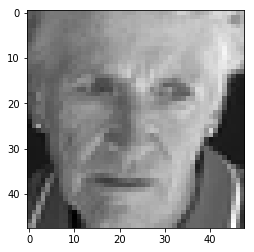

In [59]:
plt.imshow(np.array([int(val) for val in full_data.pixels[50].split()]).reshape((48,48)), cmap='gray')

In [56]:
for i in range(full_data.shape[0]):
    if full_data.Usage[i]=='Training':
        expression = expressions[full_data.emotion[i]]
        path = 'train/'+expression+'/'
        img = np.array([int(val) for val in full_data.pixels[i].split()]).reshape((48,48))
        imgname = '{:08d}.jpg'.format(i)
        plt.imsave(path+imgname, img, cmap='gray')

In [69]:
for expression in expressions:
    files = os.listdir('train/{}'.format(expression))
    val_fns = np.random.choice(files, size=int(len(files)*0.2), replace=False)
    for f in val_fns:
        os.rename('train/{}/{}'.format(expression, f), 'valid/{}/{}'.format(expression, f))

In [83]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz=sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    data = ImageClassifierData.from_paths('/home/paperspace/Yadi', tfms = tfms, bs=bs, num_workers=4)
    return data if sz<300 else data.resize(340, 'tmp')

In [128]:
arch = resnext50
data = get_data(48, 64)

In [129]:
learn = ConvLearner.pretrained(arch, data=data, precompute=True, ps=0.5)

In [130]:
learn.lr_find()

 85%|████████▍ | 304/359 [00:04<00:00, 61.82it/s, loss=7.92]


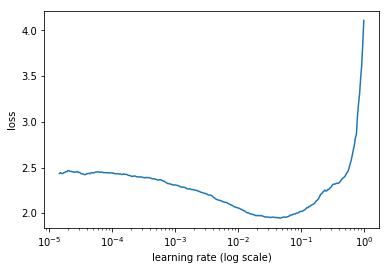

In [131]:
learn.sched.plot()

In [132]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.627036   1.521121   0.416826  
    1      1.557211   1.486284   0.431632                   



[array([1.48628]), 0.43163212002663015]

In [133]:
learn.precompute=False
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.545417   1.456705   0.442432  
    1      1.540572   1.458692   0.443303                   
    2      1.5341     1.448453   0.44278                    



[array([1.44845]), 0.44278000349928703]

In [134]:
learn.set_data(get_data(96, 64))

In [135]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.506073   1.412606   0.463856  
    1      1.465999   1.389764   0.471521                   



[array([1.38976]), 0.4715206411278968]

In [136]:
learn.unfreeze()
lr=np.array([1e-2/9,1e-2/3,1e-2])

In [137]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.207078   1.128129   0.574116  
    1      1.062963   1.004938   0.627417                   
    2      0.85872    0.979643   0.644313                    
    3      0.954182   0.995155   0.639784                    
    4      0.755242   0.969718   0.656506                    
    5      0.569056   1.0035     0.664518                    
    6      0.430592   1.025248   0.667654                    



[array([1.02525]), 0.6676537189785143]

In [105]:
learn.save('facial-resnext50-96')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
0.668698832955931